In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches

from src.utils.video_utils import get_video, get_frame_from_video
from src.utils.ground_utils import get_model_from, get_mask

DATA_PATH = '../data/'
GENERATED_PATH = '../generated/'
LDR_PATH = f'{DATA_PATH}ldr/'
DATA_MANUAL_PATH = f'{DATA_PATH}sky_ground_segmentation/manual_scene_masks/'
GENERATED_MANUAL_PATH = f'{GENERATED_PATH}sky_ground_segmentation/manual_scene_masks/'

In [4]:
ground_model_type = 'deeplabv3mobilenetv3large'
ground_model_save_path = f"{DATA_PATH}sky_ground_segmentation/models/{ground_model_type}_ranger_pretrained.pth"
ground_model = get_model_from(model_save_path=ground_model_save_path, model_type=ground_model_type)

✅ Loaded pretrained model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


In [5]:
def plot_scene_segmentation(part_number = 1, scene_number = 1):
    scene_path = f'{LDR_PATH}processed/P{part_number}Scene{scene_number:02d}.mp4'
    scene_video = get_video(scene_path)
    scene_frame, _ = get_frame_from_video(scene_video, 3, split=False, masked=True, reframed=True)

    # Save frame
    scene_save_path = f'{GENERATED_MANUAL_PATH}images/P{part_number}Scene{scene_number:02d}.png'
    if not os.path.exists(scene_save_path):
        cv2.imwrite(scene_save_path, scene_frame)
        print(f'💾 Saved frame from scene {scene_number} at {scene_save_path}')
        return

    # Get manual mask
    scene_manual_path = f'{DATA_MANUAL_PATH}/P{part_number}Scene{scene_number:02d}.png'
    if not os.path.exists(scene_manual_path):
        print(f'❌ No manual mask found for scene {scene_number} at {scene_manual_path}')
        return
    else:
        scene_manual_mask = cv2.imread(scene_manual_path, cv2.IMREAD_GRAYSCALE) > 0
        print(f'📁 Loaded manual mask for scene {scene_number} at {scene_manual_path}')

    # Get ground mask
    scene_frame = cv2.cvtColor(scene_frame, cv2.COLOR_BGR2RGB) / 255.0
    scene_ground_mask = get_mask(scene_frame, ground_model)

    # Get accuracy
    scene_accuracy = (scene_ground_mask == scene_manual_mask).mean()
    print(f'📊 Accuracy for scene {scene_number}: {scene_accuracy * 100:.2f}%')

    # Get IoU
    scene_intersection = np.logical_and(scene_ground_mask, scene_manual_mask)
    scene_union = np.logical_or(scene_ground_mask, scene_manual_mask)
    scene_iou = np.sum(scene_intersection) / np.sum(scene_union)
    print(f'📊 IoU for scene {scene_number}: {scene_iou * 100:.2f}%')

    # Plot
    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(1, 2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(scene_frame)
    ax0.set_title('Original image')
    ax0.set_xticks([])
    ax0.set_yticks([])

    # Get colored mask differences
    red_mask = np.zeros(scene_manual_mask.shape)
    red_mask = np.stack([red_mask, red_mask, red_mask], axis=-1)
    red_mask[scene_ground_mask == 0] = [0, 0, 0]
    red_mask[scene_ground_mask == 1] = [1, 1, 1]
    red_mask[(scene_ground_mask != scene_manual_mask) & (scene_manual_mask == 0)] = [1, 0, 0]
    red_mask[(scene_ground_mask != scene_manual_mask) & (scene_manual_mask == 1)] = [0, 0.7, 0.7]
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.imshow(red_mask)
    ax1.set_title('Misclassification Types')
    ax1.set_xticks([])
    ax1.set_yticks([])

    plt.suptitle(f'Ground segmentation for Scene {scene_number:02d}')

    # Add legend for misclassification
    legend_patches = [
        mpatches.Patch(color='red', label='Misclassified Sky'),
        mpatches.Patch(color='darkcyan', label='Misclassified Ground')
    ]
    plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Save plot
    scene_plot_save_path = f'{GENERATED_MANUAL_PATH}ground_segmentation_part{part_number}_scene{scene_number:02d}_diffs.png'
    plt.savefig(scene_plot_save_path, bbox_inches='tight')
    print(f'💾 Saved plot for scene {scene_number} at {scene_plot_save_path}')

    plt.tight_layout()
    plt.show()

📁 Loaded manual mask for scene 1 at ../data/sky_ground_segmentation/manual_scene_masks//P1Scene01.png
📊 Accuracy for scene 1: 98.22%
📊 IoU for scene 1: 95.75%
💾 Saved plot for scene 1 at ../generated/sky_ground_segmentation/manual_scene_masks/ground_segmentation_part1_scene01_diffs.png


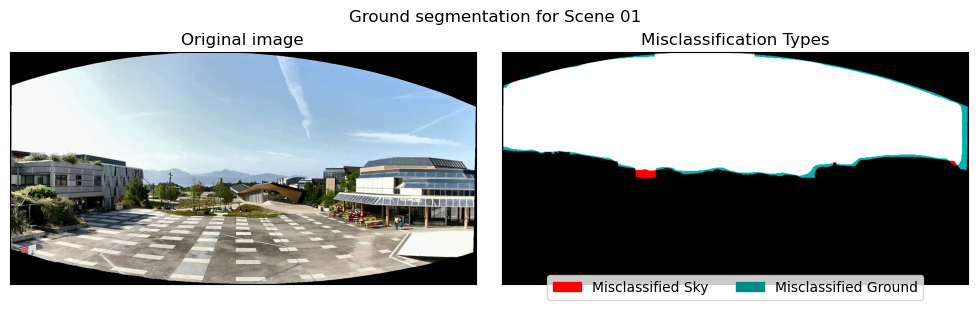

In [5]:
plot_scene_segmentation(1, 1)

📁 Loaded manual mask for scene 8 at ../data/sky_ground_segmentation/manual_scene_masks//P3Scene08.png
📊 Accuracy for scene 8: 97.88%
📊 IoU for scene 8: 93.01%
💾 Saved plot for scene 8 at ../generated/sky_ground_segmentation/manual_scene_masks/ground_segmentation_part3_scene08_diffs.png


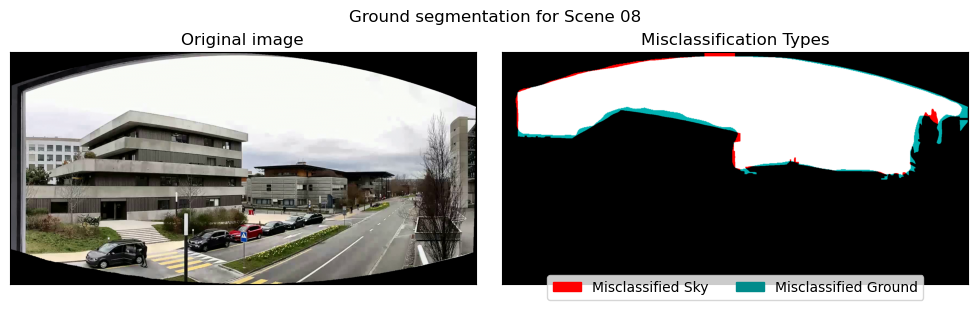

In [6]:
plot_scene_segmentation(3, 8)

📁 Loaded manual mask for scene 3 at ../data/sky_ground_segmentation/manual_scene_masks//P3Scene03.png
📊 Accuracy for scene 3: 98.04%
📊 IoU for scene 3: 90.76%
💾 Saved plot for scene 3 at ../generated/sky_ground_segmentation/manual_scene_masks/ground_segmentation_part3_scene03_diffs.png


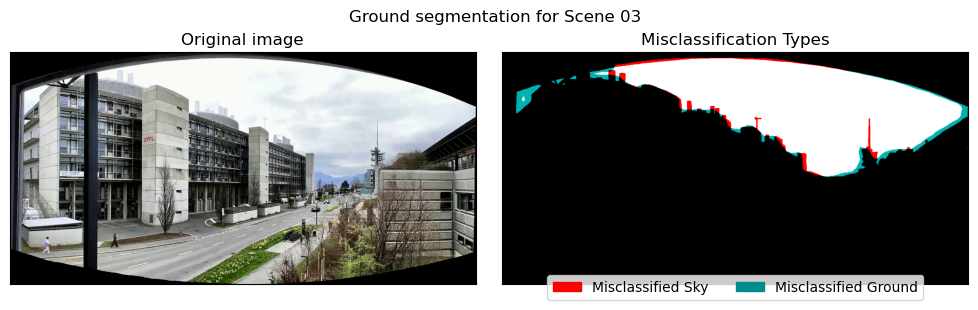

In [7]:
plot_scene_segmentation(3, 3)

In [8]:
accuracies = [98.22, 97.88, 98.04]
print(f'Average accuracy: {np.mean(accuracies):.2f}%')
print(f'Standard deviation: {np.std(accuracies):.2f}%')

ious = [95.75, 93.01, 90.76]
print(f'Average IoU: {np.mean(ious):.2f}%')
print(f'Standard deviation: {np.std(ious):.2f}%')

Average accuracy: 98.05%
Standard deviation: 0.14%
Average IoU: 93.17%
Standard deviation: 2.04%
